In [1]:
import tensorflow as tf
import numpy as np

# import neural net code
import nn
import model_portugal.nn_model as nn_model

# import data loader
import load_data.load_npy as ld

# import ipywidgets (interaction library)
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# import ploting library
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.colorbar import colorbar
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.colors as colors

from scipy.stats import norm

the segnet model

In [2]:
initializer = tf.contrib.layers.xavier_initializer()
af = tf.nn.leaky_relu
phs, ls, vs = nn_model.prediction_network(initializer, af)

Tensor("e1_c_0:0", shape=(?, 256, 256, 16), dtype=float32)
Tensor("e1_c_1:0", shape=(?, 256, 256, 16), dtype=float32)
Tensor("e1:0", shape=(?, 128, 128, 16), dtype=float32)
Tensor("e2_c_0:0", shape=(?, 128, 128, 64), dtype=float32)
Tensor("e2_c_1:0", shape=(?, 128, 128, 64), dtype=float32)
Tensor("e2:0", shape=(?, 64, 64, 64), dtype=float32)
Tensor("e3_c_0:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("e3_c_1:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("e3:0", shape=(?, 32, 32, 128), dtype=float32)
Tensor("concat:0", shape=(?, 32, 32, 132), dtype=float32)
Tensor("d3_c_0:0", shape=(?, 32, 32, 64), dtype=float32)
Tensor("d3_c_1:0", shape=(?, 32, 32, 64), dtype=float32)
output shape [64, 64]
Tensor("d3:0", shape=(?, 64, 64, 64), dtype=float32)
Tensor("d2_c_0:0", shape=(?, 64, 64, 16), dtype=float32)
Tensor("d2_c_1:0", shape=(?, 64, 64, 16), dtype=float32)
output shape [128, 128]
Tensor("d2:0", shape=(?, 128, 128, 16), dtype=float32)
Tensor("p_c_0:0", shape=(?, 128, 128, 1), dtyp

the terrain data

In [3]:
batch_num=8
path_terrain = "data/portugal/terrain.npy"
path_water_level = "data/portugal/water_level.npy"
path_rain_pattern = "data/portugal/rain_pattern.txt"

patch_terrain, patch_water_levels, rain_patterns, grid_shape, img_shape = ld.load_terrain_grid(path_terrain, path_water_level, path_rain_pattern, nn_model.IMG_SIZE)

start a session and load the model

In [4]:
path_model="data/model/portugal_shuffle_pattern/-499"

sess=tf.Session()
tf.global_variables_initializer().run(session=sess)
saver = tf.train.Saver()
saver.restore(sess,path_model)

INFO:tensorflow:Restoring parameters from data/model/portugal_shuffle_pattern/-499


making prediction for one rain pattern

In [5]:
def make_prediction(pattern):
    IMG_SIZE=nn_model.IMG_SIZE
    watermap = colors.LinearSegmentedColormap.from_list("watermap", plt.cm.Blues(np.linspace(0.15,1,256)), N=256)
    
    patch_num = len(patch_terrain)
    predict_water_level = np.zeros([grid_shape[0] * IMG_SIZE,grid_shape[1] * IMG_SIZE])
    i = 0
    while i < patch_num:
        start = i
        end = min(i + batch_num,patch_num)

        # index of patches, from start to end
        index = np.arange(start=start,stop=end)
        # h, w position of patches
        h = index // grid_shape[1]
        w = index % grid_shape[1]
        # rain patther of patches, constant array
        id_pattern = np.zeros_like(index,dtype=np.uint8)

        predict = sess.run(ls["prediction"], feed_dict={phs["x1"]:patch_terrain[index], phs["x2"]:pattern[id_pattern]})

        # assemble patches
        for j in range(end - start):
            predict_water_level[h[j] * IMG_SIZE:(h[j] + 1) * IMG_SIZE, w[j] * IMG_SIZE:(w[j] + 1) * IMG_SIZE] = predict[j]
            # set mask for the result
            mask=patch_terrain[index[j],:,:,1]==1
            predict_water_level[h[j] * IMG_SIZE:(h[j] + 1) * IMG_SIZE, w[j] * IMG_SIZE:(w[j] + 1) * IMG_SIZE][mask]=np.nan
            
        i+=batch_num

    fig = plt.figure(figsize=(30,12),constrained_layout=True)
    gs = GridSpec(1, 4, figure=fig)
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1:])

    ax1.set_ylim(0,160)
    ax1.plot(pattern[0])
    colorbar(ax2.imshow(predict_water_level,cmap=watermap,vmin=0,vmax=2), cax=make_axes_locatable(ax2).append_axes("right", size="4%", pad="2%"))
    
    plt.show()

generate one rain pattern and then make prediction

In [6]:
def generate_rain_pattern(mu,sigma,minval,maxval):
    n=nn_model.PATTERN_RESOLUTION
    arr=norm.pdf(np.arange(n)/(n-1) * 10,mu,sigma)
    arr/=np.max(arr)
    arr*=(maxval-minval)
    arr+=minval
    # display the rain pattern
    make_prediction(arr[np.newaxis])

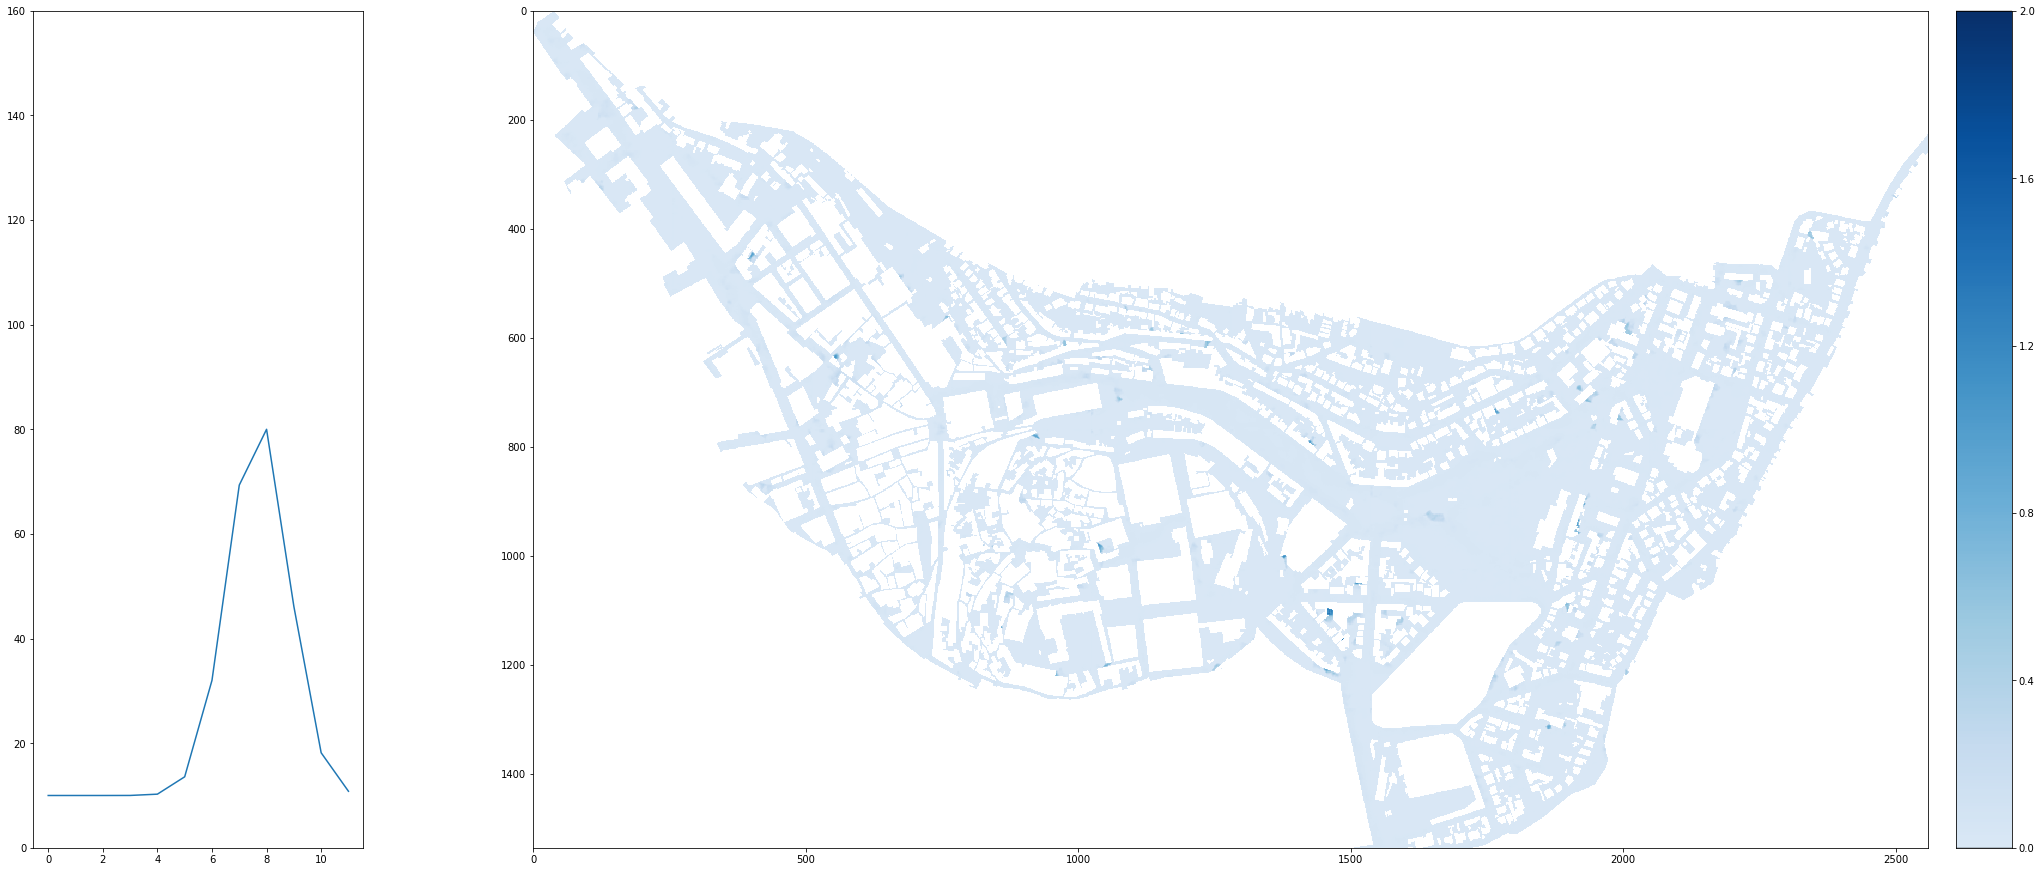

In [7]:
generate_rain_pattern(7,1,10,80)

interactive version

In [8]:
interact(generate_rain_pattern,mu=widgets.FloatSlider(min=0,max=nn_model.PATTERN_RESOLUTION,step=0.5,value=nn_model.PATTERN_RESOLUTION/2),sigma=widgets.FloatSlider(min=0.1,max=2,step=0.1,value=0.1),minval=widgets.IntSlider(min=0,max=40,step=10,value=20),maxval=widgets.IntSlider(min=80,max=160,step=10,value=80))

interactive(children=(FloatSlider(value=6.0, description='mu', max=12.0, step=0.5), FloatSlider(value=0.1, des…

<function __main__.generate_rain_pattern>